Data Source: https://designcensus.org/

### Import data

In [115]:
import numpy as np
import pandas as pd
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_ALL, '')
%matplotlib inline
sns.set_context("notebook", font_scale=1.2)

In [ ]:
df = pd.read_csv('DesignCensus2017_Data.csv')

In [ ]:
print('There a a total of ' + str(len(df.columns)) + ' columns.')

# Part I, Pre-processing

### Column name dictionary

In [ ]:
col_dict = {}
for col in df.columns:
    index, desc = col.split(' --')
    col_dict['V_' + str(index)] = desc

In [ ]:
def df_with_column_names(df, col_dict):
    df_v2 = df
    df_v2.columns = [col_dict[col] for col in df_v2.columns]
    return df_v2

In [368]:
col_dict

{'V_1': " I've worked in design for:",
 'V_1-1': " I've worked in design for:-1-4 years",
 'V_1-2': " I've worked in design for:-10-14 years",
 'V_1-3': " I've worked in design for:-15-20 years",
 'V_1-4': " I've worked in design for:-20+ years",
 'V_1-5': " I've worked in design for:-5-9 years",
 'V_1-6': " I've worked in design for:-Less than 1 year",
 'V_10': 'My immediate team is:',
 'V_10-1': 'My immediate team is:-',
 'V_10-2': 'My immediate team is:-11-20 people',
 'V_10-3': 'My immediate team is:-2-4 people',
 'V_10-4': 'My immediate team is:-20+ people',
 'V_10-5': 'My immediate team is:-5-10 people',
 'V_10-6': 'My immediate team is:-Just me',
 'V_11': 'My work touches these industries or sectors:',
 'V_11_1': 'My work touches these industries or sectors:-Air Transportation',
 'V_11_10': 'My work touches these industries or sectors:-Advertising',
 'V_11_11': 'My work touches these industries or sectors:-Chemical',
 'V_11_12': 'My work touches these industries or sectors:-Ente

### Classify columns (continuous, categorical, multiple pipe)

In [ ]:
df.columns = map(lambda x : 'V_' + str(x+1), list(range(len(df.columns)))) 

In [ ]:
continous_cols = ['V_18', 'V_37']

In [ ]:
pipe_col = ['V_2', 'V_3','V_5','V_7','V_11','V_19',\
            'V_24', 'V_27', 'V_28', 'V_31', 'V_32',\
            'V_33', 'V_40', 'V_41', 'V_42', 'V_43']

In [ ]:
cate_cols = list(set(df.columns) - set(continous_cols))
cate_cols.sort(key = lambda x : int(x.split('_')[1]))

### Summary of null value for each column

In [ ]:
dff = pd.DataFrame(columns=['Column','Desc', 'Null'])
for col in df.columns:
    num_null = df[col].isnull().sum()
    dff = dff.append({'Column': col, 'Desc' : col_dict[col], 'Null' : num_null }, ignore_index=True)
dff

### ** Take a look at Salary Outliers

In [ ]:
print('The 99% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 99))))

print('The 90% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 90))))

print('The 85% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 85))))

In [ ]:
# take a look at salary vs. age
dff = pd.DataFrame()
dff['salary'] = df['V_18'] / 1000
dff['age'] = df['V_37']
dff['salary over million'] = dff['salary'] > 1000
sns.lmplot(data = dff, x = 'salary', y = 'age', fit_reg = False, hue = 'salary over million')
plt.xlabel('Salary (thousand)')
plt.ylabel('Age')

In [ ]:
# export a separate file with salary over million record
# df_with_column_names(df[df.V_18 > 1000000], col_dict).to_csv('output_salary_over_million.csv', index = False)

### **Break "Age" into groups

In [ ]:
def age_break(x):
    if (x < 20): return ('Younger than 20')
    elif (x <= 25): return ('20 to 25')
    elif (x <= 30): return ('25 to 30')
    elif (x <= 35): return ('30 to 35')
    elif (x <= 40): return ('35 to 40')
    elif (x <= 45): return ('40 to 45')
    elif (x <= 50): return ('45 to 50')
    else: return ('Older than 50')

df['V_37'] = df['V_37'].apply(lambda x : age_break(x))
cate_cols.append('V_37')
continous_cols.remove('V_37')

### **Exclude outliers for salary

In [ ]:
## Remove outliers for salary
# 1. Null values 
# 2. zero salary
# 3. Top 1% salary

df = df[~((df.V_18.isnull()) | 
          (df.V_18 == 0) | 
          (df.V_18 > 210000))]

df = df.reset_index()
df = df.drop('index', axis = 1)

### **Done for Jon to export raw data with and without salary outliers

In [ ]:
raw_df = pd.read_csv('DesignCensus2017_Data.csv')
salary = raw_df['18 --My annual salary is:']
raw_df_salary_outliers  = raw_df [((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_excluding_outliers  = raw_df [~((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_salary_outliers.to_csv('./export_csv/raw_data_salary_outliers.csv', index = False)
raw_df_excluding_outliers.to_csv('./export_csv/raw_data_excluding_salary_outliers.csv', index = False)
del raw_df, raw_df_salary_outliers, raw_df_excluding_outliers

### Script to deal with columns with pipe

In [ ]:
df['V_36'] = df['V_36'].astype(np.object)
df = df.replace(np.nan,'', regex=True)
pipe_col_dict = {}

for col in pipe_col:
    options = set()
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                options.add(arr)
    
    pipe_col_dict[col] = {}
    
    index = 1
    for option in options:
        sub_col = col + '_' + str(index)
        df.loc[:,sub_col] = 0
        pipe_col_dict[col][option] = sub_col
        col_dict[sub_col] = col_dict[col] + '-' + option
        index += 1

In [ ]:
# this part takes a few minutes to run
for col in pipe_col:
    row_num = 0;
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                sub_col = pipe_col_dict[col][arr]
                df.loc[row_num, sub_col] += 1
        row_num += 1

### Output csv w/ and w/o column names

In [ ]:
df.to_csv('./export_csv/processed_output_without_column_names.csv', index = False)

In [ ]:
df_with_column_names(df, col_dict).to_csv(\
    './export_csv/processed_output_with_column_names.csv', index = False)    

# Part II, Analysis

### Read in processed data

In [ ]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv')
num_records = len(df)

### Basic Summary of each column (only show top 5)

In [ ]:
def summary_cate_col(col, top_k):
    if col in continous_cols:
        return
    
    elif col in pipe_col:
        dff = pd.DataFrame(columns=['Options','Count','Percent'])
        for key, value in pipe_col_dict[col].items():
            count = df[value].sum()
            dff = dff.append({'Options': key, 'Count' : count}, ignore_index=True)
    
    else:
        dff = pd.DataFrame(df[col].value_counts())
        dff.reset_index(inplace=True)
        dff.columns = ['Options','Count']
    
    dff['Percent'] = dff.Count / num_records
    dff = dff.sort_values(by = 'Percent', ascending = False).head(top_k)
    dff = dff.style.format({'Percent': '{:,.2%}'.format})
    return dff

### **Change `top_k` below: summary_cate_col(col, 5)

In [ ]:
for col in cate_cols:
    display(str(col) + ' : ' + col_dict[col])
    display(summary_cate_col(col, 5))

### **Further explore salary by plotting `salary` vs. all columns

In [ ]:
# 1. For columns without pipes
cate_cols_v2 = list(set(cate_cols) - set(pipe_col))
cate_cols_v2.remove('V_35') # "Right now, I can't stop listening to:" - No fixed options
cate_cols_v2.remove('V_36') # "I live in:" - Zipcode
cate_cols_v2.remove('V_8') # "I'm not working because:" - null
cate_cols_v2.sort(key = lambda x : int(x.split('_')[1]))

In [ ]:
# All figs are saved under 'fig' folder
for col in cate_cols_v2:
    groupedvalues = df.groupby(col, as_index = False).agg({'V_18': np.mean}).sort_values(by = 'V_18')
    order = list(groupedvalues[col])
    plt.figure(figsize=(10,10))
    g=sns.barplot(x='V_18', y=col, data=df, estimator= np.mean, \
                order = order,  palette="Blues_d")
    plt.xlim(0,max(groupedvalues['V_18'] + 10000))  
    
    # add data labels
    ax = plt.gca()
    for p,val in zip(ax.patches,groupedvalues['V_18']):
        ax.annotate("{0:n}".format(int(val)), # value
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 5), textcoords='offset points',# offset
                    va="center", size = 12) #text align and font size
        
    #plot axes and export
cz
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.gcf().clear()

In [143]:
# 2. For columns with pipes
dff = pd.DataFrame(columns = ['Col', 'Option', 'Salary'])
for col in pipe_col:
    for option, sub_col in pipe_col_dict[col].items():
        salary = df.loc[df[sub_col] == 1, 'V_18'].mean()
        dff = dff.append({'Col': col, 'Option' : option, 'Salary' : salary }, \
                         ignore_index=True)

In [ ]:
# All figs are saved under 'fig' folder
for col in pipe_col:
    dfff = dff[dff.Col == col].sort_values(by = 'Salary')
    order = list(dfff['Option'])
    plt.figure(figsize=(10,10))
    sns.barplot(x = 'Salary', y = 'Option', data = dfff, estimator= np.mean, \
                order = order, palette="Blues_d")
    plt.xlim(0, max(dfff['Salary']) + 10000) 
    
    # add data labels
    ax = plt.gca()
    for p,val in zip(ax.patches,dfff['Salary']):
        ax.annotate("{0:n}".format(int(val)), #value
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 0), textcoords='offset points',# offset
                    va="center", size = 12) # text align and font size
     
    #plot axes and export    
    plt.ylabel('Salary')
    plt.xlabel(col_dict[col])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.gcf().clear()

# Part III, Further explore 

In [409]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv')

### Example of a heatmap

Text(31,0.5,'My immediate team is:')

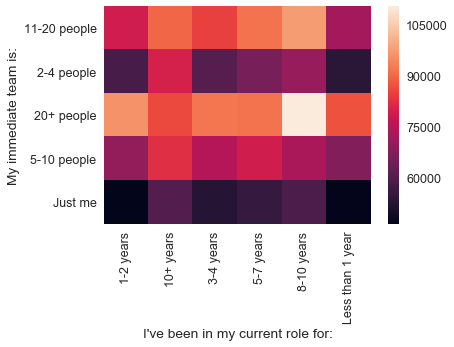

In [429]:
sns.set(font_scale=1.25)
pivot_table=pd.pivot_table(df, index='V_10', columns='V_16', values='V_18', aggfunc=np.mean)
sns.heatmap(pivot_table)
plt.xlabel(col_dict['V_16'])
plt.ylabel(col_dict['V_10'])

### Generate one-hot coded columns for categorical variables

In [403]:
for col in cate_cols_v2:
    df.replace(np.nan,'', regex=True, inplace=True)
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(df[col])
    feature = feature.reshape(df.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    for i in range(feature.shape[1]):
        df[col + '-' + str(i + 1)] = np.array(np.matrix(feature).transpose())[i]
        col_dict[col + '-' + str(i + 1)] = col_dict[col] + '-' + label_encoder.classes_[i]
    df.drop(col, axis = 1, inplace = True)

for col in pipe_col:
    df.drop(col, axis = 1, inplace = True)

for col in ['V_8', 'V_35', 'V_36']:
    df.drop(col, axis = 1, inplace = True)

In [406]:
# output a csv with all columns converted to numeric
df.to_csv('./export_csv/processed_output_all_numeric.csv', index = False)

### Run a off-the-shelf prediction model

In [374]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [376]:
Xtr = df[[col for col in df.columns if col != 'V_18']]
Ytr = df['V_18']
dtrain = xgb.DMatrix(Xtr, label=Ytr)

In [377]:
xgb_pars = {'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.5, 'lambda': 1, 'booster' : 'gbtree', 'silent':0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
max_num_round = 200
xgb_cv = xgb.cv(xgb_pars, dtrain, max_num_round, nfold = 5,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

In [379]:
selected_num_round = 200
xgb_model = xgb.train(xgb_pars, dtrain, selected_num_round)

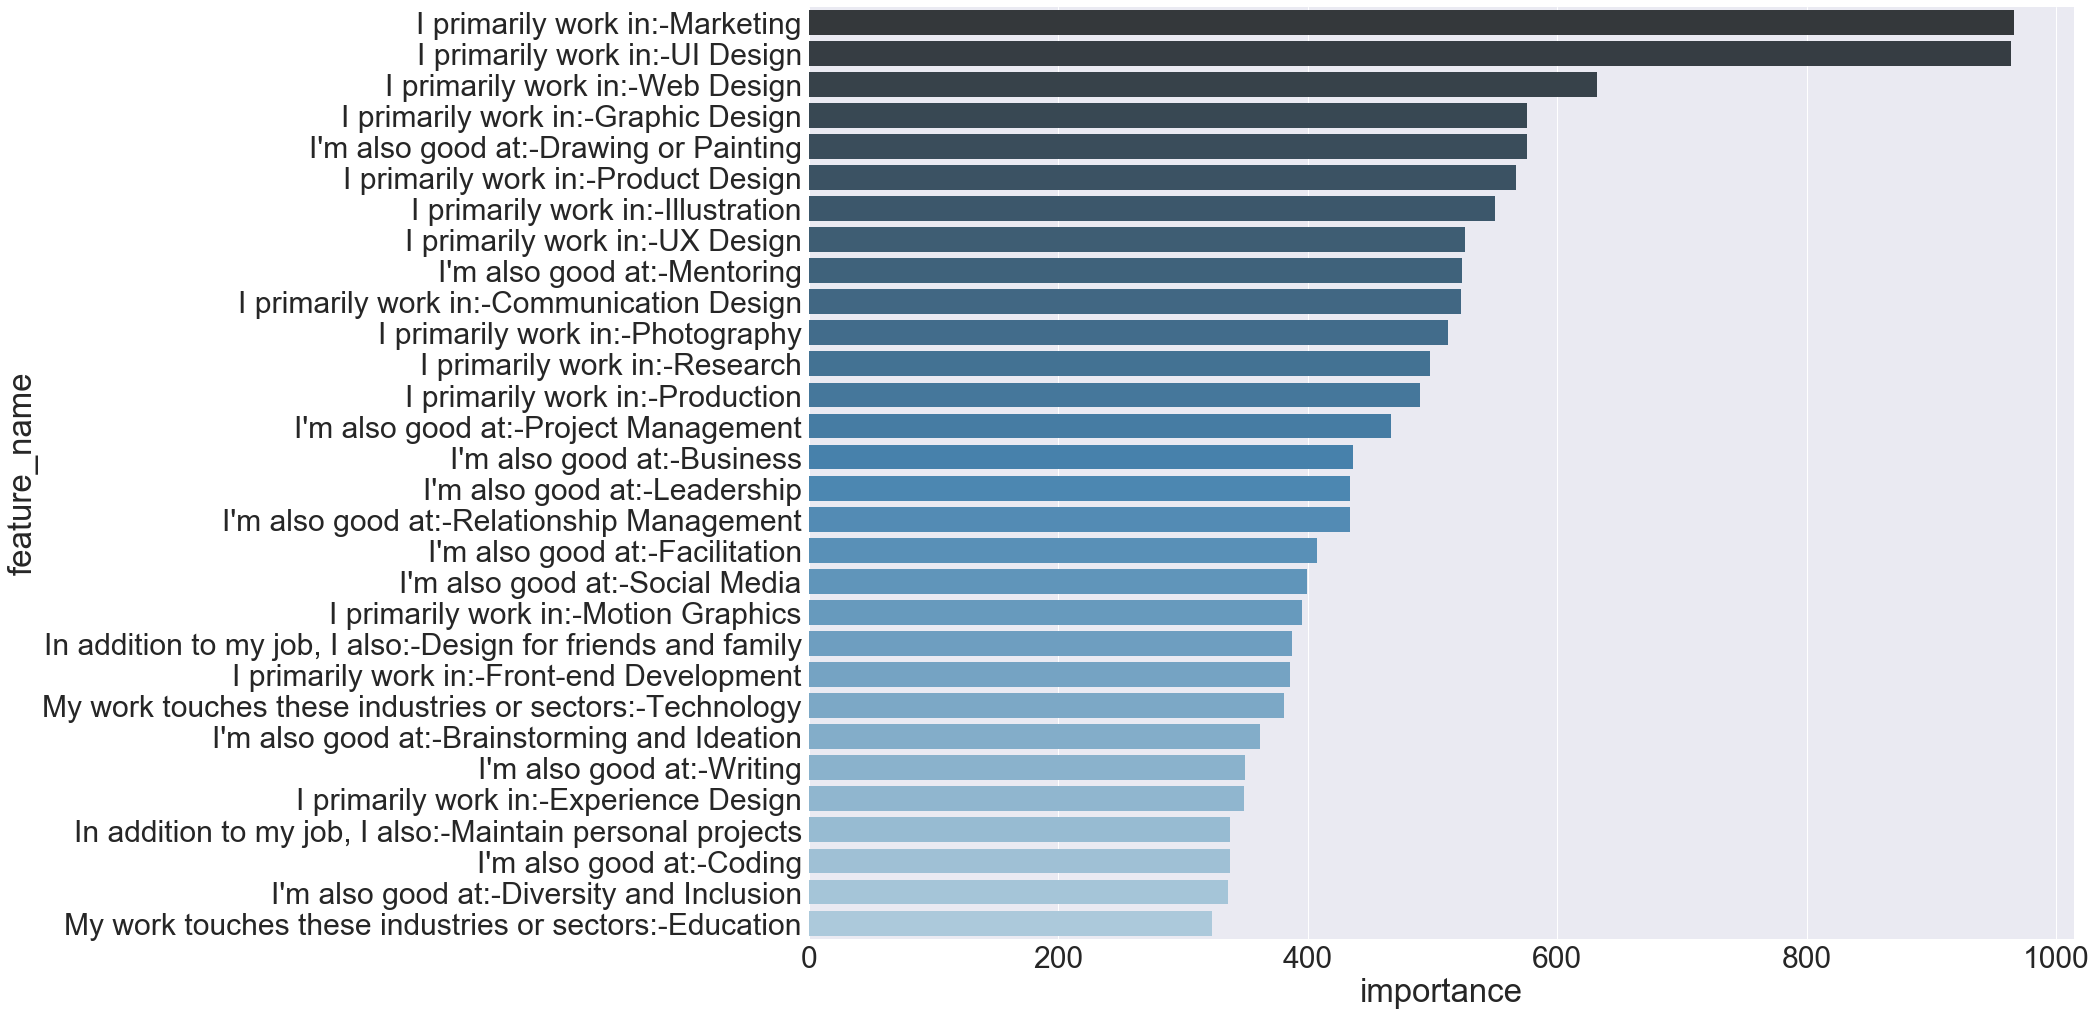

In [387]:
# Examine feature importance
feature_importance_dict = xgb_model.get_fscore()
feature_importance_table = pd.DataFrame({'feature_name': list(feature_importance_dict.keys()), 
                                         'importance': list(feature_importance_dict.values())})
feature_importance_table.sort_values(by ='importance', ascending=False, inplace= True)
feature_importance_table['feature_name'] = [col_dict[col][-70:] for col in feature_importance_table['feature_name']]

sns.set(font_scale=3)
sns.factorplot(x="importance", y="feature_name",data=feature_importance_table.head(30), 
               size = 15, kind="bar",palette="Blues_d", aspect=2)
plt.tight_layout()
sns.set(font_scale=1)